In [1]:
#git clone https://github.com/SoccerNet/sn-spotting
#pip install -r requirements.txt
!pip install tqdm opencv-python SoccerNet lime shap pandas
!pip install SoccerNet
!pip install soccernet-downloader

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement soccernet-downloader (from versions: none)
ERROR: No matching distribution found for soccernet-downloader


In [2]:
# Define the dataset path
sn_path = "/scratch/czz7bf/soccernet_data/SoccerNetData"

# Ensure the directory exists
import os
os.makedirs(sn_path, exist_ok=True)

In [3]:
# Install the SoccerNet package (if not already installed)
#!pip install git+https://github.com/SoccerNet/SoccerNet.git

# Alternatively, if using a specific downloader module:
#!pip install soccernet-downloader

In [4]:
from SoccerNet.Downloader import SoccerNetDownloader

# Initialize the downloader with the dataset path
downloader = SoccerNetDownloader(LocalDirectory=sn_path)
print("SoccerNetDownloader initialized.")

SoccerNetDownloader initialized.


In [5]:
# Download the dataset
downloader.downloadGames(
    files=["Labels-v3.json", "Frames-v3.zip"],
    split=["train", "valid", "test"],
    task="frames",
    verbose=True
)
print("Dataset download initiated. This may take some time...")

/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Labels-v3.json already exists
/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Frames-v3.zip already exists
/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Labels-v3.json already exists
/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Frames-v3.zip already exists
/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United/Labels-v3.json already exists
/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United/Frames-v3.zip already exists
/scratch/czz7bf/soccernet_data/SoccerNetData/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/Labels-v3.json already exis

In [6]:
# Install required libraries if not already installed
!pip install torch torchvision scikit-learn lime shap matplotlib seaborn

# Import libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import lime
from lime import lime_image
import shap
from skimage.segmentation import slic
from sklearn.preprocessing import LabelEncoder

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import os
import zipfile

def extract_frames(zip_path, output_dir):
    """
    Extract frames from a zip file to the specified output directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Extracted frames to: {output_dir}")

# Define the root directory
root_dir = "/scratch/czz7bf/soccernet_data/SoccerNetData"

# Traverse all leagues, seasons, and match folders
for league in os.listdir(root_dir):
    league_path = os.path.join(root_dir, league)
    if os.path.isdir(league_path):
        for season in os.listdir(league_path):
            season_path = os.path.join(league_path, season)
            if os.path.isdir(season_path):
                for game in os.listdir(season_path):
                    game_dir = os.path.join(season_path, game)
                    if os.path.isdir(game_dir):
                        zip_path = os.path.join(game_dir, "Frames-v3.zip")
                        if os.path.exists(zip_path):
                            extract_frames(zip_path, game_dir)
                        else:
                            print(f"Warning: Frames-v3.zip not found in {game_dir}")

Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2016-09-23 - 21-30 Dortmund 3 - 1 SC Freiburg
Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2017-02-04 - 20-30 Dortmund 1 - 0 RB Leipzig
Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2016-10-22 - 16-30 Ingolstadt 3 - 3 Dortmund
Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2016-09-20 - 21-00 Wolfsburg 1 - 5 Dortmund
Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2016-12-10 - 17-30 FC Koln 1 - 1 Dortmund
Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2016-10-29 - 19-30 Dortmund 0 - 0 Schalke
Extracted frames to: /scratch/czz7bf/soccernet_data/SoccerNetData/germany_bundesliga/2016-2017/2016-12-20 - 22-00 Dortmund 1 - 1 FC Augsburg
Extracted frames to: /scr

In [33]:
import json
import pandas as pd

def parse_annotations(annotation_path):
    """
    Parse a single Labels-v3.json file and extract event metadata.
    """
    with open(annotation_path, "r") as f:
        data = json.load(f)

    events = []
    actions = data.get("actions", {})
    for img_name, action_data in actions.items():
        metadata = action_data.get("imageMetadata", {})
        label = metadata.get("label")
        game_time = metadata.get("gameTime")
        local_path = metadata.get("localpath")

        # Skip invalid entries
        if not label or not game_time or not local_path:
            continue

        event_data = {
            "image_file": img_name,
            "label": label,
            "game_time": game_time,
            "local_path": local_path
        }
        events.append(event_data)

    return events

# Collect all annotations
all_events = []

# Traverse all leagues, seasons, and match folders
for league in os.listdir(root_dir):
    league_path = os.path.join(root_dir, league)
    if os.path.isdir(league_path):
        for season in os.listdir(league_path):
            season_path = os.path.join(league_path, season)
            if os.path.isdir(season_path):
                for game in os.listdir(season_path):
                    game_dir = os.path.join(season_path, game)
                    if os.path.isdir(game_dir):
                        annotation_path = os.path.join(game_dir, "Labels-v3.json")
                        if os.path.exists(annotation_path):
                            events = parse_annotations(annotation_path)
                            all_events.extend(events)

# Convert to DataFrame
events_df = pd.DataFrame(all_events)
print(f"Total events parsed: {len(events_df)}")
print(events_df.head())

Total events parsed: 12764
  image_file             label  game_time  \
0      0.png  Shots off target  1 - 02:06   
1      1.png   Shots on target  1 - 04:08   
2      2.png  Shots off target  1 - 15:11   
3      3.png  Ball out of play  1 - 16:16   
4      4.png  Shots off target  1 - 17:39   

                                          local_path  
0  germany_bundesliga/2016-2017/2016-09-23 - 21-3...  
1  germany_bundesliga/2016-2017/2016-09-23 - 21-3...  
2  germany_bundesliga/2016-2017/2016-09-23 - 21-3...  
3  germany_bundesliga/2016-2017/2016-09-23 - 21-3...  
4  germany_bundesliga/2016-2017/2016-09-23 - 21-3...  


Using subset

In [9]:
import pandas as pd

# Sample a smaller subset (e.g., 10% of the data)
subset_fraction = 0.5  # 10%
subset_df = events_df.sample(frac=subset_fraction, random_state=42)

top_labels = subset_df['label'].value_counts().head(7).index.tolist()
subset_df_7 = subset_df[subset_df['label'].isin(top_labels)].reset_index(drop=True)
# Save the subset for reproducibility (optional)
subset_df_7.to_csv("subset_data.csv", index=False)
print(subset_df_7.head())

  image_file             label  game_time  \
0     13.png  Ball out of play  1 - 44:33   
1     28.png  Shots off target  2 - 37:36   
2      7.png  Shots off target  1 - 18:00   
3     11.png              Foul  1 - 28:55   
4     26.png  Shots off target  2 - 43:18   

                                          local_path  
0  europe_uefa-champions-league/2014-2015/2014-12...  
1  england_epl/2016-2017/2017-05-13 - 14-30 Manch...  
2  italy_serie-a/2016-2017/2017-05-20 - 19-00 Chi...  
3  germany_bundesliga/2014-2015/2015-04-25 - 16-3...  
4  england_epl/2015-2016/2015-09-26 - 17-00 Manch...  


In [10]:
from sklearn.model_selection import train_test_split

label_encoder= LabelEncoder()
subset_df_7['label_encoded'] = label_encoder.fit_transform(subset_df_7['label'])

train_df, temp_df = train_test_split(subset_df_7, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

Training samples: 4915, Validation samples: 614, Test samples: 615


train_dataset = SoccerEventDataset(train_df, root_dir="/scratch/czz7bf/soccernet_data/SoccerNetData", transform=transform)
val_dataset = SoccerEventDataset(val_df, root_dir="/scratch/czz7bf/soccernet_data/SoccerNetData", transform=transform)
test_dataset = SoccerEventDataset(test_df, root_dir="/scratch/czz7bf/soccernet_data/SoccerNetData", transform=transform)

Back to original

In [36]:
top_labels = events_df['label'].value_counts().head(7).index.tolist()
events_df_7 = events_df[events_df['label'].isin(top_labels)].reset_index(drop=True)
label_encoder= LabelEncoder()
events_df_7['label_encoded'] = label_encoder.fit_transform(events_df_7['label'])

train_df, temp_df = train_test_split(events_df_7, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [11]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(events_df, test_size=0.2, random_state=42)

In [37]:
from sklearn.preprocessing import LabelEncoder

# Encode Labels as integers
label_encoder = LabelEncoder()
events_df_7["label_encoded"] = label_encoder.fit_transform(events_df_7["label"])
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])
val_df["label_encoded"] = label_encoder.transform(val_df["label"])

print(events_df.columns)

Index(['image_file', 'label', 'game_time', 'local_path'], dtype='object')


In [38]:
import torch
from PIL import Image

class SoccerEventDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]["image_file"]
        local_path = self.dataframe.iloc[idx]["local_path"]
        img_path = os.path.join(self.root_dir, local_path, img_name)
        label = self.dataframe.iloc[idx]["label_encoded"]  # Use encoded label

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

New Transform splitting training and validation

In [39]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset = SoccerEventDataset(train_df, root_dir, transform=train_transform)
val_dataset = SoccerEventDataset(val_df, root_dir="/scratch/czz7bf/soccernet_data/SoccerNetData", transform=val_transform)
test_dataset = SoccerEventDataset(test_df, root_dir="/scratch/czz7bf/soccernet_data/SoccerNetData",transform=val_transform)

In [40]:
# Define the prediction function
def predict_fn(images):
    """
    Takes a batch of images and returns prediction probabilities.
    """
    transform = val_transform
    # Convert images to tensors and normalize
    pil_images = [Image.fromarray(image.astype('uint8')) for image in images]
    inputs = torch.stack([transform(img) for img in pil_images]).to(device)
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
    
    return probabilities

In [41]:
import torch
import torch.nn as nn
import torchvision.models as models

def create_model(architecture="resnet50", num_classes=10):
    """
    Creates and returns a pre-trained model with the final layer replaced for classification.
    
    Parameters:
        architecture (str): The model architecture to use ("resnet50" or "efficientnet_b3").
        num_classes (int): The number of output classes.
    
    Returns:
        model: A PyTorch model with the specified architecture and updated final layer.
    """
    if architecture == "resnet50":
        # Load pre-trained ResNet-50
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # Replace the final fully connected layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze last two blocks and final classifier
        for name, param in model.named_parameters():
            if 'layer3' in name or 'layer4' in name or 'fc' in name:
                param.requires_grad = True
    elif architecture == "efficientnet_b3":
        # Load pre-trained EfficientNet-B3
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        # Replace the final classifier layer
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze final convolutional blocks and classifier
        for name, param in model.named_parameters():
            if 'features.6' in name or 'features.7' in name or 'classifier' in name:
                param.requires_grad = True
    else:
        raise ValueError(f"Unsupported architecture: {architecture}. Choose 'resnet50' or 'efficientnet_b3'.")
    
    return model

# Number of unique event labels
num_classes = len(label_encoder.classes_)

# Create the model (choose architecture here)
architecture = "resnet50"  # Change to "resnet50" if needed
model = create_model(architecture=architecture, num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model ({architecture}) loaded and moved to device: {device}")

Model (resnet50) loaded and moved to device: cpu


In [42]:
from sklearn.utils.class_weight import compute_class_weight

class_names = sorted(train_df['label'].unique())
y_train = np.array(train_df['label'])
class_weights = compute_class_weight('balanced', classes=np.array(class_names), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

from sklearn.utils.class_weight import compute_class_weight
# Calculate weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(subset_df_7['label_encoded']),
    y=subset_df_7['label_encoded']
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [43]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [44]:
from torch.utils.data import WeightedRandomSampler

label_indices = [class_names.index(label) for label in train_df['label']]
class_counts = np.bincount(label_indices)
weights = 1. / class_counts
sample_weights = [weights[i] for i in label_indices]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Train model

In [45]:
from sklearn.metrics import accuracy_score
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0.0
    best_model_state = None
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

        model.train()

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds. Best Val Accuracy: {best_accuracy:.4f}")

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model


In [46]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1, Train Loss: 0.9797
Validation Loss: 2.0916, Accuracy: 0.1726
Epoch 2, Train Loss: 0.7997
Validation Loss: 2.1530, Accuracy: 0.2671
Epoch 3, Train Loss: 0.7224
Validation Loss: 2.0360, Accuracy: 0.3184
Epoch 4, Train Loss: 0.6582
Validation Loss: 2.0586, Accuracy: 0.3070
Epoch 5, Train Loss: 0.6227
Validation Loss: 2.0629, Accuracy: 0.3689
Epoch 6, Train Loss: 0.6005
Validation Loss: 1.9429, Accuracy: 0.3917
Epoch 7, Train Loss: 0.5523
Validation Loss: 1.9350, Accuracy: 0.4088
Epoch 8, Train Loss: 0.5502
Validation Loss: 1.9516, Accuracy: 0.4235
Epoch 9, Train Loss: 0.5200
Validation Loss: 2.0472, Accuracy: 0.4560
Epoch 10, Train Loss: 0.5232
Validation Loss: 2.0057, Accuracy: 0.4479
Training completed in 8454.89 seconds. Best Val Accuracy: 0.4560


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Evaluation of Model

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Evaluate the model on the validation set
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get top-5 predictions
        _, top5_preds = torch.topk(outputs, k=5, dim=1)
        all_preds.extend(top5_preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Top-5 Accuracy
top5_accuracy = np.mean([label in preds for label, preds in zip(all_labels, all_preds)])

# Compute other metrics
accuracy = accuracy_score(all_labels, all_preds[:, 0])  # Top-1 accuracy
precision = precision_score(all_labels, all_preds[:, 0], average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds[:, 0], average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds[:, 0], average='weighted', zero_division=0)

# Print results
print(f"Validation Accuracy (Top-1): {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
print(f"Validation Accuracy (Top-5): {top5_accuracy:.4f}")

Validation Accuracy (Top-1): 0.3550
Precision: 0.5552, Recall: 0.3550, F1-Score: 0.3819
Validation Accuracy (Top-5): 0.8673


In [48]:
class_names = test_df['label'].unique()


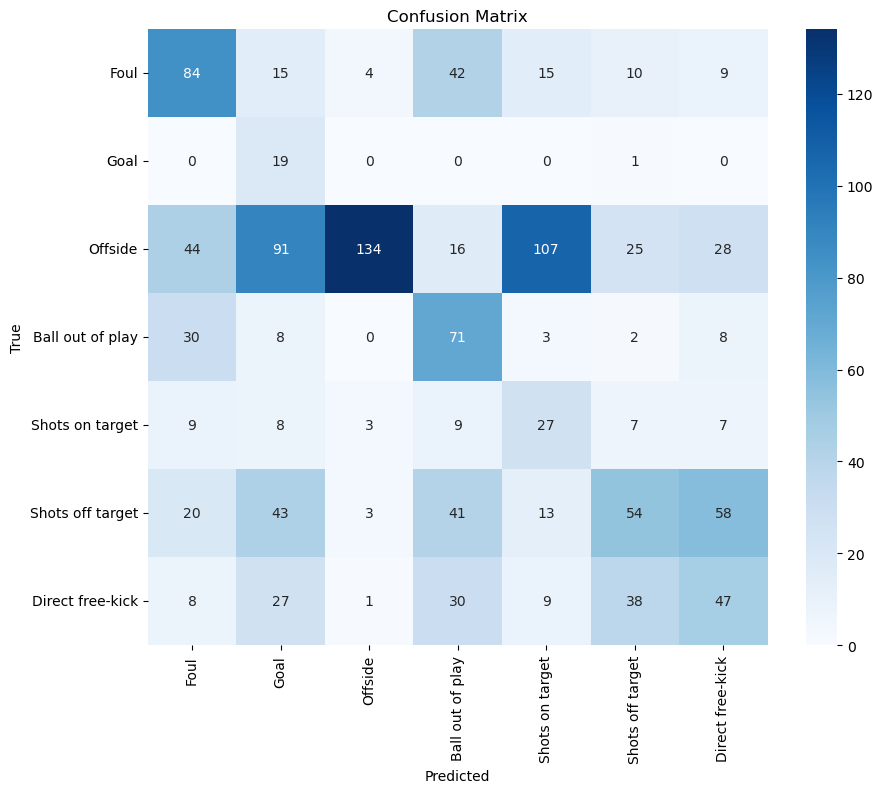

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds[:, 0])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


New LIME: use test so its quicker

  0%|          | 0/1000 [00:00<?, ?it/s]

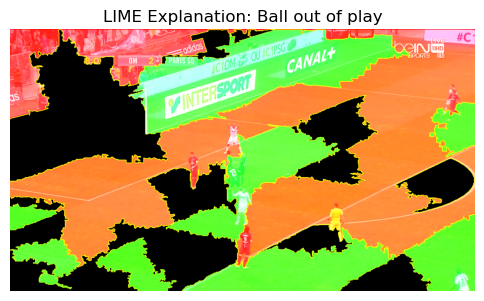

  0%|          | 0/1000 [00:00<?, ?it/s]

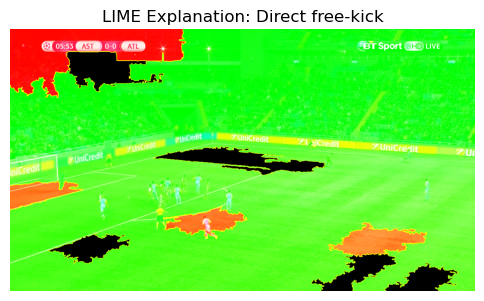

  0%|          | 0/1000 [00:00<?, ?it/s]

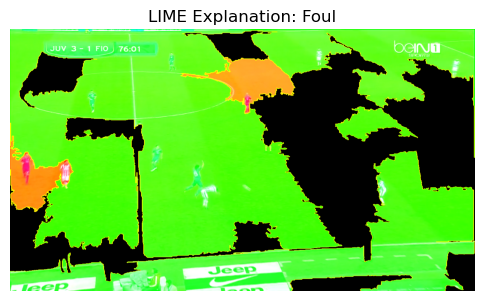

  0%|          | 0/1000 [00:00<?, ?it/s]

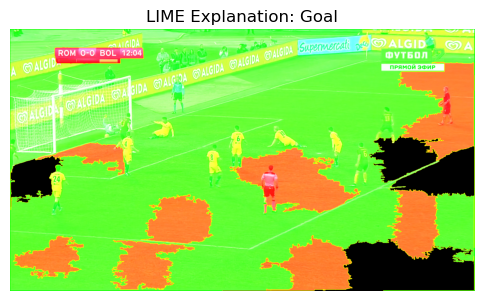

  0%|          | 0/1000 [00:00<?, ?it/s]

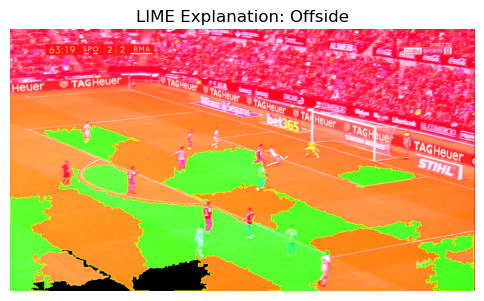

  0%|          | 0/1000 [00:00<?, ?it/s]

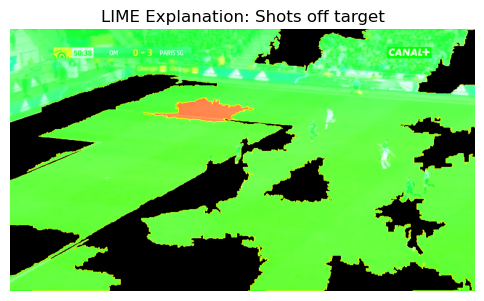

  0%|          | 0/1000 [00:00<?, ?it/s]

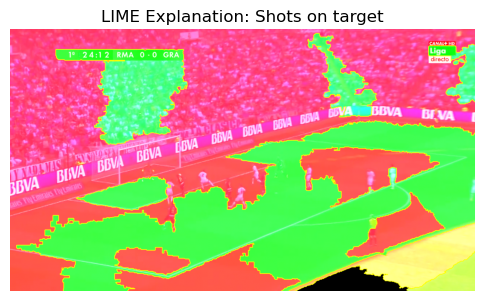

In [55]:
from skimage.segmentation import mark_boundaries

one_image_per_label = test_df.groupby('label').first().reset_index()

# Your class name list in correct order (make sure it matches model output)
class_names = sorted(test_df['label'].unique())  # or custom ordered if needed

# Set up the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Loop through each label and explain one image
for idx, row in one_image_per_label.iterrows():
    label_name = row['label']
    label_index = class_names.index(label_name)
    
    # Load the image
    img_path = os.path.join(root_dir, row['local_path'], row['image_file'])
    image = Image.open(img_path).convert("RGB")
    input_image = np.array(image)

    # Run LIME explanation
    explanation = explainer.explain_instance(
        input_image,
        classifier_fn=predict_fn,  # your prediction function
        segmentation_fn=lambda x: slic(x, n_segments=100, compactness=3), 
        top_labels=len(class_names),
        hide_color=0,
        num_samples=1000
    )

    # Check if the label was included in LIME explanation
    if label_index in explanation.local_exp:
        temp, mask = explanation.get_image_and_mask(
            label=label_index,
            positive_only=False, #if true may hide useful regions so try false
            num_features=40, #increase features to reveal more context (ex: 15)
            hide_rest=True
        )

        # Show the result
        plt.figure(figsize=(6, 6))
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME Explanation: {label_name}")
        plt.axis("off")
        plt.show()


In [51]:
correct = 0
total = 0
mismatches = []
skipped = 0

for idx, row in test_df.iterrows():
    img_path = os.path.join(root_dir, row["local_path"], row["image_file"])
    transform = val_transform
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Skipping {img_path} due to read error: {e}")
        skipped += 1
        continue

    input_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)

        # Defensive check for index out of bounds
        if pred_idx >= len(class_names):
            print(f"⚠️ Predicted index {pred_idx} exceeds class_names length ({len(class_names)}). Skipping.")
            skipped += 1
            continue

        pred_label = class_names[pred_idx]
        true_label = row["label"]

        total += 1
        if pred_label == true_label:
            correct += 1
        else:
            mismatches.append((img_path, true_label, pred_label, probs[pred_idx]))

# Accuracy
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Model Accuracy on Labeled Dataset: {accuracy:.2%}")
print(f"❌ Mismatches: {len(mismatches)}")
print(f"🚫 Skipped samples: {skipped}")

# Preview top 5 mismatches
print("\n🔍 Sample mismatches:")
for path, true, pred, conf in mismatches[:5]:
    print(f"{os.path.basename(path)} — Predicted: {pred} ({conf:.2f}) | True: {true}")



✅ Model Accuracy on Labeled Dataset: 42.26%
❌ Mismatches: 709
🚫 Skipped samples: 0

🔍 Sample mismatches:
30.png — Predicted: Offside (0.35) | True: Foul
26.png — Predicted: Shots off target (0.35) | True: Offside
24.png — Predicted: Goal (0.75) | True: Ball out of play
14.png — Predicted: Offside (0.62) | True: Foul
23.png — Predicted: Shots on target (0.28) | True: Shots off target


Integrating Grad-CAM

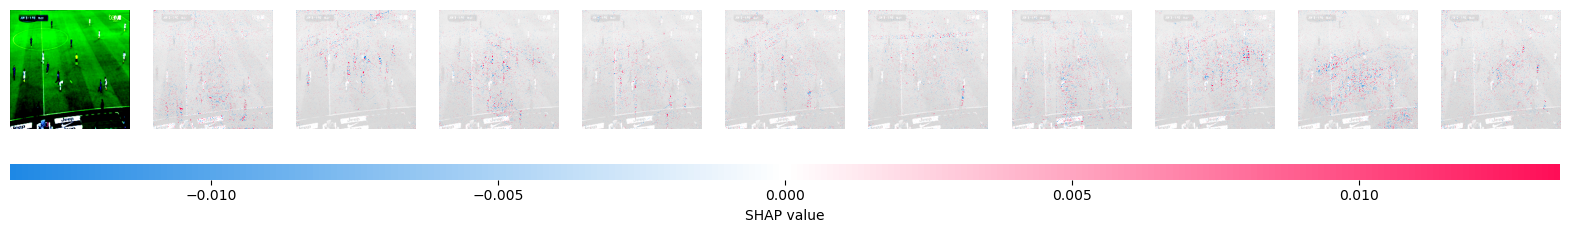

In [53]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import shap
from torch.utils.data import DataLoader

# Step 1: Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Step 2: Prepare the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 3: Create a DataLoader for the background dataset
# Use a small subset of the training data as the background dataset
background_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Extract a single batch as the background dataset
background_data, _ = next(iter(background_loader))
background_data = background_data.to(device)

# Step 4: Create the SHAP explainer
explainer = shap.GradientExplainer(model, background_data)

# Step 5: Select test samples to explain
# Use the test dataset or a subset of it
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

# Step 6: Compute SHAP values
shap_values = explainer.shap_values(test_images)

# Aggregate SHAP values across the batch
shap_values_aggregated = [np.sum(sv, axis=0) for sv in shap_values]

# Normalize input images for visualization
inputs_for_shap = test_images.cpu().numpy().transpose(0, 2, 3, 1)  # Shape: (batch_size, H, W, C)
inputs_for_shap = np.clip(inputs_for_shap, 0, 1)  # Ensure values are in [0, 1]

# Visualize SHAP values for the first image in the batch
input_image_for_shap = inputs_for_shap[0]  # Shape: (224, 224, 3)
shap.image_plot([sv for sv in shap_values_aggregated], input_image_for_shap)
plt.show()

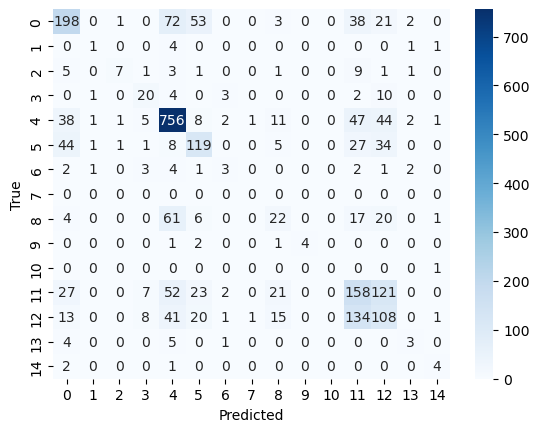

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# If all_preds is a 2D array of shape (N, 5), get top-1 predictions
top1_preds = [preds[0] if isinstance(preds, (list, np.ndarray)) else preds for preds in all_preds]

# Now compute the confusion matrix
cm = confusion_matrix(all_labels, top1_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
